# MNIST Digit Recognition using Feed Forward Neural Network

## Introduction

In this notebook, we aim to build a Feed Forward Neural Network (also known as a Multilayer Perceptron or MLP) to recognize handwritten digits from the MNIST dataset.

## Dataset

The [MNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) (Modified National Institute of Standards and Technology) database is a large database of handwritten digits that is commonly used for training and testing in the field of machine learning. The dataset contains 60,000 training images and 10,000 testing images.

Each image in the MNIST dataset is a 28x28 grayscale image containing a digit from 0 to 9, and it is associated with a label (0-9).

## Objective

The objective of this notebook is to train a Feed Forward Neural Network to map each input image to the correct digit label. By training on the images and their associated labels from the training part of the dataset, it will 'learn' to predict which digit is written in the image.

## Neural Network Architecture

Our Feed Forward Neural Network will consist of an input layer, few hidden layers, and an output layer:
* The **input layer** will have 784 neurons (or 'units'), one for each pixel in the input image.
* The **hidden layers** will apply transformations to the inputs before reaching the output layer. The exact number of hidden layers and the number of neurons in these layers is a model hyperparameter.
* The **output layer** will have 10 neurons, representing the scores for each of the 10 possible labels (0-9).

The learning process involves adjusting the weights and biases of the network to improve the accuracy of predictions. We'll be using a variant of stochastic gradient descent to optimize the network's parameters.

## Libraries

We will be using `PyTorch`, a machine learning library in Python, for constructing and training our neural network. Other libraries such as `NumPy` and `Matplotlib` will also be used for data manipulation and visualization respectively.

By the end of this notebook, you will have a trained model which will be able to accurately predict the digit present in a given image.


#Importing libraries

In [165]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.autograd as Variable

# Defining hyper-parameters

In [166]:
hp = {
  "input_size": 28*28, # 24x24= 764 pixels
  "hidden_size": 400, # number of hidden neurons
  "out_size": 10, # number of classes [0, 9] digits
  "epochs": 10, # how many times will we pas sour entire dataset of 60k images to our network to learn from it.
  "batch_size": 100, # for one iteration, how many images we will send to the network in one go
  "learning_rate": 0.001, # how fast the model will learn
  }

#Downloading data from MNIST dataset

In [167]:
train_dataset = datasets.MNIST(root="./data",
                               train=True,
                               transform=T.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root="./data",
                               train=False,
                               transform=T.ToTensor(),
                               download=True)

#Importing Dataloader
- Dataloader will help us get the raw images into iterable format
- This iterable format of data will be used to send to the network for learning

In [168]:
from torch.utils.data import DataLoader as DL

In [169]:
train_loader = DL(dataset=train_dataset,
                  batch_size=hp["batch_size"],
                  shuffle=True)


In [170]:
test_loader = DL(dataset=train_dataset,
                  batch_size=hp["batch_size"],
                  shuffle=True)


In [171]:
# there are two ways of getting data out of the loader
# 1 using for loop
for train_features, train_labels in train_loader:
  print(train_features.shape, train_labels.shape)
  break

torch.Size([100, 1, 28, 28]) torch.Size([100])


In [172]:
# 2 using for iter and next
train_features, train_labels = next(iter(train_loader))

In [173]:
train_features.shape, train_labels.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

#Visualizing the data

In [174]:
import matplotlib.pyplot as plt


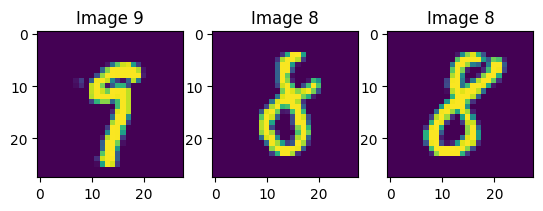

In [175]:
num_img = 3
fig, axs = plt.subplots(1, num_img)

for i in range(0, num_img):
    img = train_features[i]
    img = torch.squeeze(img, dim=0)
    axs[i].imshow(img)

    # Convert label to int and then to string before setting the title
    label = int(train_labels[i].detach().cpu().numpy())
    axs[i].set_title('Image ' + str(label))

plt.show()


#Designing the Neural Network

## Class Definition

We create a class `Net` which builds upon PyTorch's `nn.Module` base class. This class contains methods and attributes necessary for creating a customizable neural network architecture.

### Structure

This neural network consists of the following sequence of layers and functions:

* A Linear (Fully-Connected) Layer (also known as 'Dense' layer)
* ReLU (Rectified Linear Unit) Activation Function
* Another Linear Layer
* Another Linear Layer

Now, let's break down each of these components:

- **First Linear Layer (`fc1`):** This layer is a linear transformation,  `y = Wx + b`, where `W` and `b` are learnable parameters. This layer takes in `input_size` number of features from the input data and transforms them into an intermediate `hidden_size` dimensional space.

- **ReLU Activation (`relu`):** Non-linear activation function to introduce non-linearity into the model, hence allowing the network to learn more complex functions. It squashes all negative values to zero and maintains positive values as is. We use ReLU after first linear layer.

- **Second Linear Layer (`fc2`):** This layer takes in `hidden_size` features, applies a linear transformation, and retains the same number of features (`hidden_size`).

- **Third Linear Layer (`fc3`):** The final linear layer takes in `hidden_size` features and transforms them into `out_size` dimensions. This `out_size` typically corresponds to the number of output classes of the problem at hand.

### Forward method

The `forward` method of the class defines the forward pass computations of the neural network. PyTorch's differentiable runtime will automatically generate the backward pass computations (gradients) for us.

* The initial input tensor `x` goes through the first linear layer (`fc1`) and the non-linear activation function (ReLU).

* The output is again passed through the second linear layer (`fc2`).

* The output from this layer is finally passed through the third linear layer (`fc3`).

This final linear layer's output could be directly used with a certain types of loss function (like CrossEntropyLoss) for calculating the loss and updating the model parameters during training.

This `Net` class structure provides a base for a simple, customizable feed-forward network that can be used for classification tasks with PyTorch.

Note: We do not apply a final activation function at the end of the model, as we expect to use this output directly in a loss function that includes that activation. For example, when using PyTorch's cross-entropy loss function, this includes a softmax activation. However, this depends on the specific use-case and the method of training the model.

In [176]:
class Net(nn.Module):
    """
    Define a neural network class 'Net' which inherits from the 'nn.Module' class of PyTorch.
    'nn.Module' is the base class for all neural network modules.
    """

    def __init__(self, input_size, hidden_size, out_size):
        """
        Initialize the network structure.

        Parameters:
        input_size (int): Number of input neurons, equivalent to the number of input features.
        hidden_size (int): Number of neurons in the hidden layers.
        out_size (int): Number of output neurons, equivalent to the number of target classes.
        """
        # Call the init of nn.Module.
        super(Net, self).__init__()

        # Define the first linear layer with 'input_size' inputs and 'hidden_size' outputs
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Define the activation function as ReLU (Rectified Linear Unit)
        self.relu = nn.ReLU()

        # Define the second linear layer with 'hidden_size' inputs and 'hidden_size' outputs.
        # This layer takes the outputs from the first layer as inputs.
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        # Define the third linear layer with 'hidden_size' inputs and 'out_size' outputs.
        # This one will take the outputs from the second layer as inputs.
        self.fc3 = nn.Linear(hidden_size, out_size)


    def forward(self, x):
        """
        Defines the computation performed at every call.
        Note: 'forward' gets automatically called when we pass data to a nn.Module object

        Parameters:
        x (torch.Tensor): The input tensors with shape [batch_size, input_size].
        """

        # Pass the input tensors through the first linear layer and then apply the activation function
        out = self.relu(self.fc1(x))

        # Then, pass through the second linear layer and again apply the activation function
        out = self.fc2(out)

        # Finally, pass through the third linear layer
        out = self.fc3(out)

        # Here we don't apply an activation at the end of the last layer because PyTorch's
        # cross entropy loss function used for training includes softmax by default.

        return out


In [177]:
# Check if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [178]:
# Instantiate the network. Make sure to use appropriate input_size, hidden_size and out_size
def getFreshModel():
  net = Net(hp["input_size"], hp["hidden_size"], hp["out_size"])
  net.to(device)
  return net

net = getFreshModel()
# Send the model to the device


#Visualizing the Model

In [179]:
!pip install torchviz


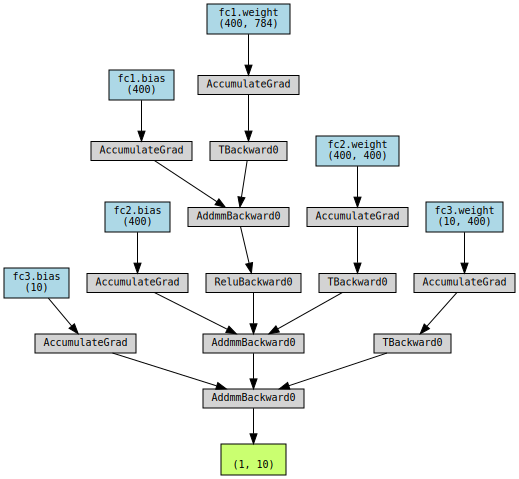

In [180]:
import torch
from torchviz import make_dot

# To visualize the model, we need to create a dummy input
# The dummy input size should match with the input size of the model
dummy_input = train_features[0].to(device)
dummy_input  = dummy_input.view(-1, 28*28)
# We use the forward pass on the dummy input
out = net(dummy_input)

# Generate the graph using the dummy input to visualize the architecture
dot = make_dot(out, params=dict(net.named_parameters()))
dot.render("model_architecture.gv", view=True)

# Display the graph
dot


In [181]:
out.shape

torch.Size([1, 10])

In [182]:
out

tensor([[ 0.0584, -0.0924,  0.0387, -0.0485,  0.0234,  0.0215,  0.0317, -0.0968,
         -0.0931, -0.0653]], grad_fn=<AddmmBackward0>)

#Visualizing the model summary

In [183]:
from torchsummary import summary


In [184]:
summary(net, input_size=(1, hp["input_size"]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 400]         314,000
              ReLU-2               [-1, 1, 400]               0
            Linear-3               [-1, 1, 400]         160,400
            Linear-4                [-1, 1, 10]           4,010
Total params: 478,410
Trainable params: 478,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.82
Estimated Total Size (MB): 1.84
----------------------------------------------------------------


#Loss function and Optimizer
- Refer to this video if you are not sure how Loss Functions work
- Refer to this video if you are not sure how Optimiers work

In [185]:
#https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
# note that CrossEntropyLoss comes with a Softmax layer therefore we dont have to create that layer in our Net model
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

In [186]:
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
net = getFreshModel()
optim_fn = torch.optim.Adam(net.parameters(),
                            lr=hp["learning_rate"])
optim_fn

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [187]:
for param in net.parameters():
  print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([400, 784])
<class 'torch.nn.parameter.Parameter'> torch.Size([400])
<class 'torch.nn.parameter.Parameter'> torch.Size([400, 400])
<class 'torch.nn.parameter.Parameter'> torch.Size([400])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 400])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


#Training the model

In [188]:
# Initialize variables to track the total number of correctly predicted samples during training
total_train = 0
correct_train = 0

# Obtain a fresh instance of the neural network model
net = getFreshModel()

# Define the optimizer for updating the model parameters using the Adam optimizer with specified learning rate
optimizer = torch.optim.Adam(net.parameters(), lr=hp["learning_rate"])

# Loop over the specified number of epochs for training the model
for epoch in range(0, hp["epochs"]):
    # Reset the count of correctly predicted samples for each epoch
    correct_train = 0
    # Initialize a variable to track the cumulative loss during training for each epoch
    running_loss = 0

    # Iterate over the batches of data in the training dataset
    for i, (imgs, labels) in enumerate(train_loader):
        # Reshape the input images to a 1D tensor
        imgs = imgs.view(-1, 28*28)
        # Move the input images and labels to the appropriate device (e.g., CPU or GPU)
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward pass: compute the predicted outputs by passing the input images through the network
        outputs = net(imgs)

        # Compute the predicted classes by selecting the class with the highest probability
        _, predicted = torch.max(outputs.data, 1)

        # Update the count of correctly predicted samples for this batch
        correct_train += (predicted == labels).sum()

        # Compute the loss between the predicted outputs and the true labels
        loss = loss_fn(outputs, labels)

        # Accumulate the loss for this batch
        running_loss += loss.item()

        # Backpropagation: compute gradients of the loss with respect to the model parameters
        optimizer.zero_grad()
        loss.backward()

        # Update the model parameters using the computed gradients
        optimizer.step()

    # Print the average training loss and accuracy for the current epoch
    print('Epoch [{}/{}], Training Loss: {:.3f}, Training Accuracy: {:.3f}%'.format(
        epoch+1, hp["epochs"], running_loss/len(train_loader), (100*correct_train.double()/len(train_dataset))))

# Print a message indicating that training is complete
print("Done Training")


Epoch [1/10], Training Loss: 0.249, Training Accuracy: 92.605%
Epoch [2/10], Training Loss: 0.093, Training Accuracy: 97.153%
Epoch [3/10], Training Loss: 0.062, Training Accuracy: 98.028%
Epoch [4/10], Training Loss: 0.046, Training Accuracy: 98.608%
Epoch [5/10], Training Loss: 0.037, Training Accuracy: 98.783%
Epoch [6/10], Training Loss: 0.029, Training Accuracy: 99.067%
Epoch [7/10], Training Loss: 0.025, Training Accuracy: 99.137%
Epoch [8/10], Training Loss: 0.023, Training Accuracy: 99.240%
Epoch [9/10], Training Loss: 0.023, Training Accuracy: 99.223%
Epoch [10/10], Training Loss: 0.020, Training Accuracy: 99.358%
Done Training


#Testing the AI Model

- The accuracy of **99.xxx%** on the test images, it appears that the network has been effectively trained.
- The high accuracy score suggests that the model has successfully learned to make correct predictions on **unseen data**, indicating a good generalization capability.
- Please note that while high accuracy is encouraging, it's typically beneficial to review other performance metrics.
  - like **precision**, **recall**, and **F1 score**
  - to fully understand the model's performance, especially in case of imbalanced data sets.

In [189]:
# Turn off gradient calculation for efficiency during evaluation
with torch.no_grad():
    # Initialize variables to track the number of correctly predicted samples and the total number of samples
    correct = 0
    total = 0

    # Iterate over batches of data in the test dataset
    for images, labels in test_loader:
        # Move the input images and labels to the appropriate device (e.g., CPU or GPU)
        images = images.to(device)
        labels = labels.to(device)

        # Flatten the input images into a 1D tensor
        images = images.view(-1, 28*28)

        # Forward pass: compute the predicted outputs by passing the input images through the network
        outputs = net(images)

        # Compute the predicted classes by selecting the class with the highest probability
        _, predicted = torch.max(outputs.data, 1)

        # Update the total count of samples
        total += labels.size(0)

        # Update the count of correctly predicted samples by comparing predicted labels with true labels
        correct += (predicted == labels).sum().item()

    # Calculate the accuracy of the network on the test images
    accuracy = 100 * correct / total

    # Print the accuracy of the network on the test dataset
    print('Accuracy of the network on the test images: {:.2f} %'.format(accuracy))


Accuracy of the network on the test images: 99.55 %


In [190]:
# Initialize variables to store true positives, false positives, and false negatives
true_positives = 0
false_positives = 0
false_negatives = 0

# Turn off gradient tracking for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        images = images.view(-1, 28*28)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)

        # Calculate true positives, false positives, and false negatives
        for pred, true_label in zip(predicted, labels):
            if pred == 1 and true_label == 1:
                true_positives += 1
            elif pred == 1 and true_label == 0:
                false_positives += 1
            elif pred == 0 and true_label == 1:
                false_negatives += 1

# Calculate precision, recall, and F1 score
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Print precision, recall, and F1 score
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_score))


Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


##Test Results
- **Precision: 1.0000**
  - Precision measures the accuracy of positive predictions. A precision of 1.0000 means that all the instances predicted as positive (e.g., belonging to a certain class) were indeed positive. In other words, there were no false positives in the predictions.

- **Recall: 1.0000**
  - Recall (also known as sensitivity) measures the ability of the classifier to correctly identify all positive instances. A recall of 1.0000 indicates that all the positive instances in the dataset were correctly identified by the classifier. There were no false negatives.

- **F1 Score: 1.0000**
  - The F1 score is the harmonic mean of precision and recall, providing a balance between the two metrics. A perfect F1 score of 1.0000 implies that both precision and recall are perfect. In this case, it suggests that the model's predictions are both precise and comprehensive, with no false positives or false negatives.

Overall, these results indicate that the model performed exceptionally well on the test dataset, achieving perfect precision, recall, and F1 score. This suggests that the model's predictions are accurate and reliable, with no misclassifications. However, it's essential to consider the possibility of overfitting or biases in the dataset when interpreting such perfect scores. Further evaluation on diverse datasets would help validate the model's generalization performance.
